In [1]:
import torch
import torch.nn.functional as F

from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [2]:
import os, random, collections
# import pandas as pd
import cv2
import numpy as np
import pandas as pd

from tqdm import tqdm as tqdm
from IPython.display import clear_output

from torchvision import transforms
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import sys
sys.path.append('../../UNetZoo/')
sys.path.append('..')


from models.DPUNet import DPUNet
from models.AlbuNet import AlbuNet

In [4]:

import sys

sys.path.append('../../inplace_abn/')

from modules import InPlaceABN

In [4]:
print(cv2.getBuildInformation())


General configuration for OpenCV 3.4.1 =====================================
  Version control:               3.4.1

  Platform:
    Timestamp:                   2018-05-19T13:50:22Z
    Host:                        Linux 4.4.0-101-generic x86_64
    CMake:                       3.9.0
    CMake generator:             Unix Makefiles
    CMake build tool:            /usr/bin/gmake
    Configuration:               Release

  CPU/HW features:
    Baseline:                    SSE SSE2 SSE3
      requested:                 SSE3
    Dispatched code generation:  SSE4_1 SSE4_2 FP16 AVX AVX2
      requested:                 SSE4_1 SSE4_2 AVX FP16 AVX2 AVX512_SKX
      SSE4_1 (3 files):          + SSSE3 SSE4_1
      SSE4_2 (1 files):          + SSSE3 SSE4_1 POPCNT SSE4_2
      FP16 (1 files):            + SSSE3 SSE4_1 POPCNT SSE4_2 FP16 AVX
      AVX (5 files):             + SSSE3 SSE4_1 POPCNT SSE4_2 AVX
      AVX2 (9 files):            + SSSE3 SSE4_1 POPCNT SSE4_2 FP16 FMA3 AVX AVX2

  C/C++:


In [5]:
from utils.dataset import ISIC_Dataset, MEAN, STD

In [6]:
# GPU_IDX = 1
PATHS = {
    'DATA': '../data/ISIC2018_Task1-2_Training_Input/',
}

In [7]:
from utils.losses import BCEDiceLoss, DiceLoss, LossBinary
from utils.metrics import calc_iou

In [8]:
from utils.augmentations import Augmentation
%load_ext autoreload
%autoreload 2

In [9]:
def infer_on_dataset(model, dataset, idx, verbose=False, suffix=''):
    image, true_mask = dataset[idx]
    pred_mask = F.sigmoid(model.forward(Variable(image.unsqueeze(0)).cuda())[0]).data.cpu().numpy()
    
    image = (image.numpy().T * STD + MEAN)[..., ::-1]
    true_mask = true_mask.numpy().T
    pred_mask = pred_mask.T
    
    if verbose:
        _, ax = plt.subplots(ncols=3, figsize=(15, 5))
        ax[0].imshow(image)
        ax[1].imshow(true_mask[..., 0])
        ax[2].imshow(pred_mask[..., 0])
    np.save('pics/image_{}'.format(suffix), image)
    np.save('pics/pred_mask_{}'.format(suffix), pred_mask)
    np.save('pics/true_mask_{}'.format(suffix), true_mask)

In [10]:
torch.cuda.set_device(0)

In [11]:
# checkpoint = '../../pytorch-dpn-pretrained/pretrained/dpn92-extra.pth'

# model = DPUNet(checkpoint=checkpoint, inplace_abn=False)
# model = model.cuda(GPU_IDX)

In [12]:
def unfreeze_bn(model):
    if isinstance(model, nn.BatchNorm2d):
        for param in model.parameters():
            param.requires_grad = True

    model = list(model.children())
    if len(model):
        for child in model:
            unfreeze_bn(child)
    return None

In [13]:
def freeze(model, end_block=-1):
    for l, child in enumerate(model.children()):
            for param in child.parameters():
                param.requires_grad = l > end_block
    return model

In [14]:
def get_datasets(data_dir, fold, prefix='_shrinked', aug_strength=1.):
    train_dataset = ISIC_Dataset(data_dir, prefix=prefix,
                                 augmentations=Augmentation(side=512, strength=aug_strength), part=fold, partsamount=4, exclude=True)
    val_dataset = ISIC_Dataset(data_dir, prefix=prefix,
                               augmentations=Augmentation(side=576), is_test=True, part=fold, partsamount=4, exclude=False)
    return train_dataset, val_dataset


def get_datagens(train_dataset, val_dataset, train_batch_size=28):
    train_datagen = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size,
                                                shuffle=True, num_workers=8)
    val_datagen = torch.utils.data.DataLoader(val_dataset, batch_size=1,
                                              shuffle=False, num_workers=0)
    return train_datagen, val_datagen


def get_model(checkpoint=None, map_location=None, devices=None):
    model = AlbuNet(num_classes=1, pretrained=True)
    model.cuda();

    if checkpoint is not None:
        cbs = torch.load(checkpoint, map_location)
        model.load_state_dict(cbs.state_dict())

    if devices is not None:
        model = torch.nn.DataParallel(model, device_ids=devices)

    return model

In [15]:
def train_on_epoch(model, loss, opt, datagen, epsilon=1e-4):
    epoch_loss = 0
    intersection, union = 0., 0.
    model.train()

    for images, masks in tqdm(datagen):
        opt.zero_grad()

        images = Variable(images).cuda()
        masks = Variable(masks > 120).cuda().float()

        predictions = model(images)
        l = loss(predictions, masks)
        pred = F.sigmoid(predictions).data.cpu().numpy()
        i, u = calc_iou(pred > 0.5,
                        masks.data.cpu().numpy(), partial=True)
        intersection += i
        union += u

        l.backward()
        opt.step()

        epoch_loss += l

    losses = epoch_loss.data.cpu().numpy() / len(datagen)
    iou = (intersection + epsilon) / (union + epsilon)
    opt.zero_grad()
    return losses, iou

In [16]:
def validate(model, loss, datagen):
    epoch_loss = 0
    intersection, union = 0., 0.
    model.eval()

    with torch.no_grad():
        for images, masks in tqdm(datagen):
            if min(images.shape[2:]) < 25:
                continue
            images = Variable(images).cuda()
            masks = Variable(masks > 120).cuda().float()

            predictions = model(images)
            l = loss(predictions, masks)
            pred = F.sigmoid(predictions).data.cpu().numpy()
            i, u = calc_iou(pred > .5, masks.data.cpu().numpy(), partial=True)
            intersection += i
            union += u

            epoch_loss += l

    losses = epoch_loss.data.cpu().numpy() / len(datagen)
    iou = intersection / union
    return losses, iou

In [17]:
def visualize(train_losses, val_losses, train_iou, val_iou):
    clear_output(wait=True)
    _, axes = plt.subplots(ncols=2, figsize=(15, 6))

    axes[0].plot(train_losses, label='Train')
    axes[0].plot(val_losses, label='Val')
    axes[0].set_title('Loss')
    axes[0].legend()
    axes[0].grid()

    axes[1].plot(train_iou, label='Train', alpha=0.5, color='C0')    
    axes[1].plot(val_iou, label='Val', alpha=0.5, color='C1')

    axes[1].plot(pd.Series.ewm(pd.Series(train_iou), span=15).mean(), label='Train ewma@15', color='C0')    
    axes[1].plot(pd.Series.ewm(pd.Series(val_iou), span=15).mean(), label='Val ewma@15', color='C1')

    axes[1].set_title('IoU')
    axes[1].legend()
    axes[1].grid()

    plt.show()

In [18]:
def dump_intermediates(model, val_dataset, fold, epoch_i):
    model.eval()
    infer_on_dataset(
        model, val_dataset, idx=0, verbose=False, suffix='fold_{}_val_idx_{}_epoch_{}'.format(fold, 0, epoch_i)
    )
    infer_on_dataset(
        model, val_dataset, idx=32, verbose=False, suffix='fold_{}_val_idx_{}_epoch_{}'.format(fold, 32, epoch_i)
    )
    infer_on_dataset(
        model, val_dataset, idx=17, verbose=True, suffix='fold_{}_val_idx_{}_epoch_{}'.format(fold, 17, epoch_i)
    )

In [19]:
def orchestrate(data_dir, fold, model_pth=None, epoch_nb=1, map_location=None, nums=[6, 3, 1, -1], lr=1e-4, aug_strength=1.,
                checkpoints_pth='checkpoints', prefix='_shrinked', verbose=False, devices=None, train_batch_size=8):
    train_dataset, val_dataset = get_datasets(data_dir, fold, prefix, aug_strength)
    train_datagen, val_datagen = get_datagens(train_dataset, val_dataset, train_batch_size=train_batch_size)
    model = get_model(model_pth, map_location, devices)

    loss = LossBinary(jaccard_weight=.3)
    opt = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    train_iou, val_iou = [], []

    for epoch_i in range(epoch_nb):
        if nums is not None:
            idx = min(3, epoch_i // 20)
            model = freeze(model, nums[idx])
            unfreeze_bn(model)
        else:
            model = freeze(model, -1)

        l, iou = train_on_epoch(model, loss, opt, train_datagen)
        train_losses.append(l)
        train_iou.append(iou)

        l, iou = validate(model, loss, val_datagen)
        val_losses.append(l)
        val_iou.append(iou)

        if verbose:
            visualize(train_losses, val_losses, train_iou, val_iou)
            dump_intermediates(model, val_dataset, fold, epoch_i)

    if (checkpoints_pth is not None) and ((epoch_i + 1) % 10 == 0):
        torch.save(model, os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}'.format(fold, epoch_i)))

    return model

In [20]:
for fold in range(1, 4):
    for i in range(1):
        model = orchestrate(
            data_dir=PATHS['DATA'], 
            fold=fold, 
            model_pth='checkpoints/fold_{}_checkpoint.epoch_99'.format(fold), 
            epoch_nb=20,
            checkpoints_pth=None, 
            prefix='_shrinked',
            lr=8e-5,
            aug_strength=.7,
            verbose=True,
            train_batch_size=14,
#             map_location={'cuda:1': ['cuda:{}'.format(g) for g in range(2)]},
            nums=None,
            devices=[0, 1]
        )
        torch.save(model, os.path.join('checkpoints', 'extra_checkpoint_{}.fold_{}'.format(i, fold)))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-f59051dfe090>", line 16, in <module>
    devices=[0, 1]
  File "<ipython-input-19-7d01ef14523f>", line 5, in orchestrate
    model = get_model(model_pth, map_location, devices)
  File "<ipython-input-14-6d0874cf014e>", line 19, in get_model
    model.cuda();
  File "/usr/local/lib/python3.5/dist-packages/torch/nn/modules/module.py", line 249, in cuda
    return self._apply(lambda t: t.cuda(device))
  File "/usr/local/lib/python3.5/dist-packages/torch/nn/modules/module.py", line 176, in _apply
    module._apply(fn)
  File "/usr/local/lib/python3.5/dist-packages/torch/nn/modules/module.py", line 176, in _apply
    module._apply(fn)
  File "/usr/local/lib/python3.5/dist-packages/torch/nn/modules/module.py", line 182, in _apply
    param.data = fn(param.data)
  File "/usr/l

KeyboardInterrupt: 

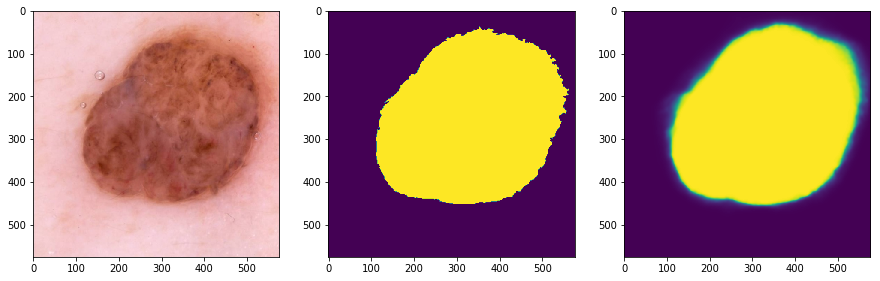

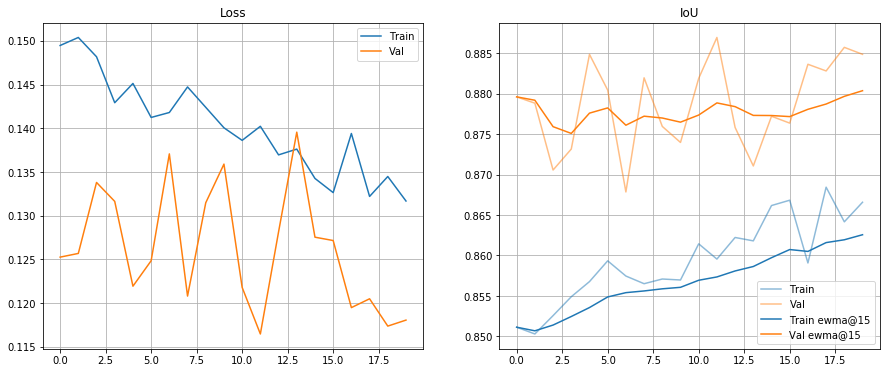

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


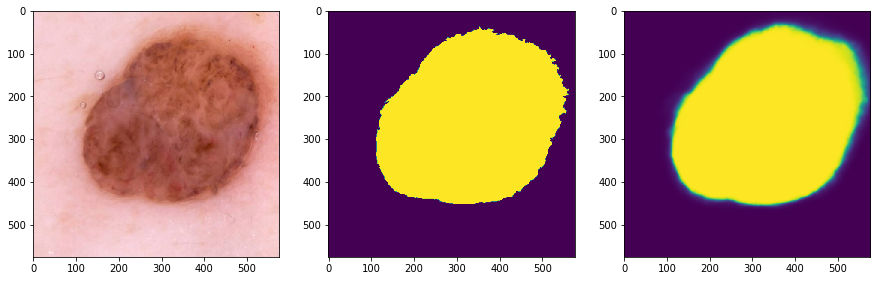

In [21]:
for fold in range(1):
    for i in range(1):
        model = orchestrate(
            data_dir=PATHS['DATA'], 
            fold=fold, 
            model_pth='checkpoints/fold_{}_checkpoint.epoch_99'.format(fold), 
            epoch_nb=20,
            checkpoints_pth=None, 
            prefix='_shrinked',
            lr=8e-5,
            aug_strength=.7,
            verbose=True,
            train_batch_size=14,
#             map_location={'cuda:1': ['cuda:{}'.format(g) for g in range(2)]},
            nums=None,
            devices=[0, 1]
        )
        torch.save(model, os.path.join('checkpoints', 'extra_checkpoint_{}.fold_{}'.format(i, fold)))

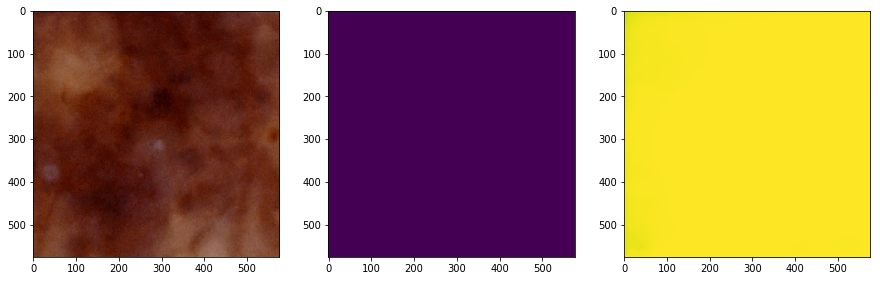

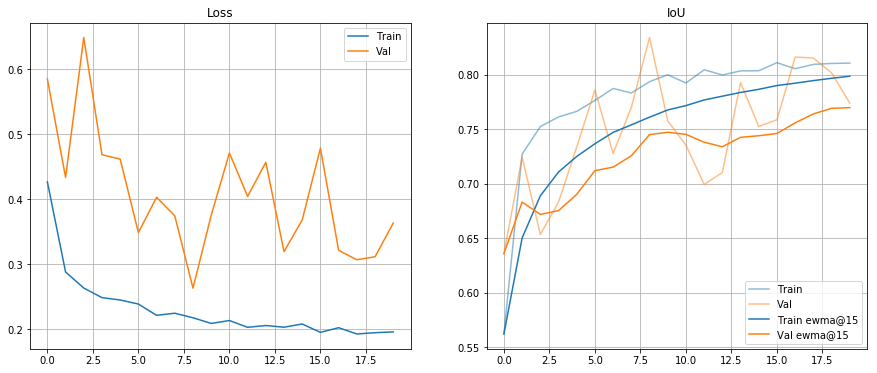

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


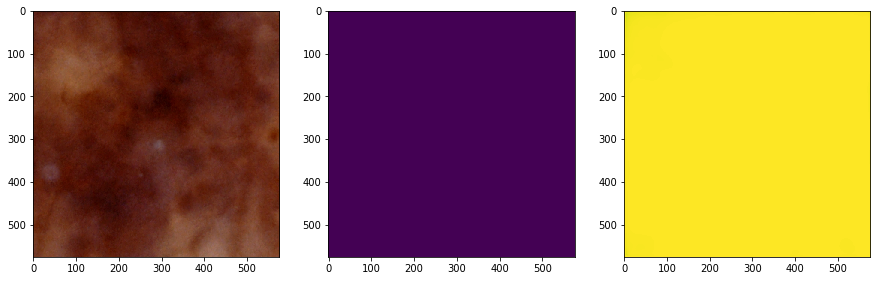

In [20]:
for fold in range(4):
    model = orchestrate(
        data_dir=PATHS['DATA'], 
        fold=fold, 
        model_pth='full_checkpoints/fold_{}_checkpoint.epoch_19'.format(fold),
        epoch_nb=20,
        checkpoints_pth='full_checkpoints', 
        prefix='',
        lr=4e-5,
        aug_strength=.5,
        verbose=True,
        train_batch_size=14,
        nums=None,
        devices=[0, 1]
    )
#     torch.save(model, os.path.join('checkpoints', 'extra_.fold_{}'.format(fold)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


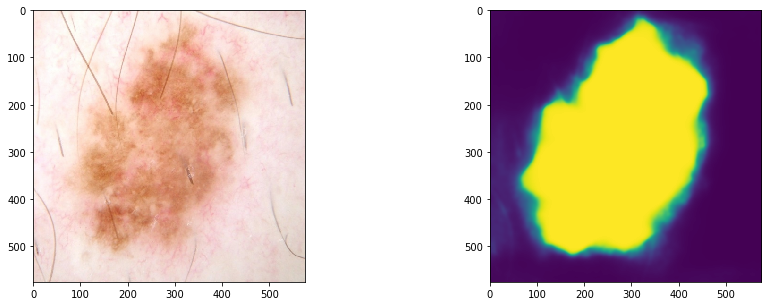

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


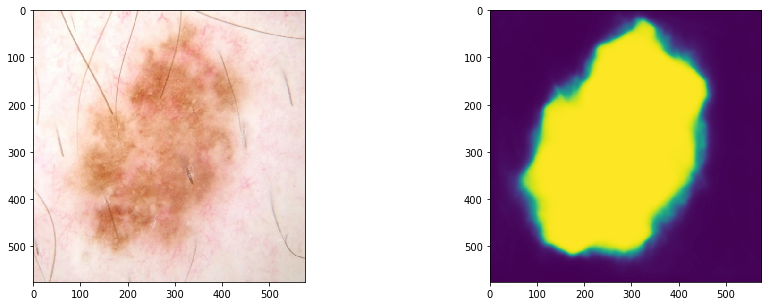

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


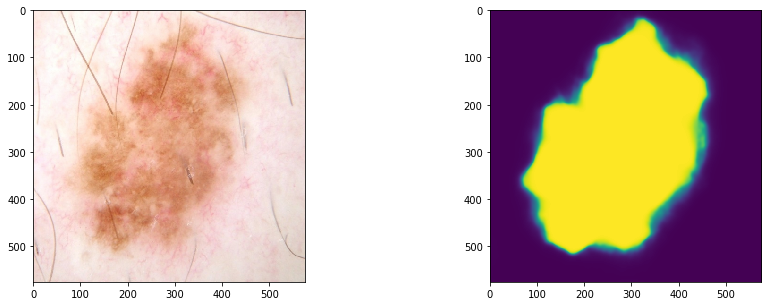

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


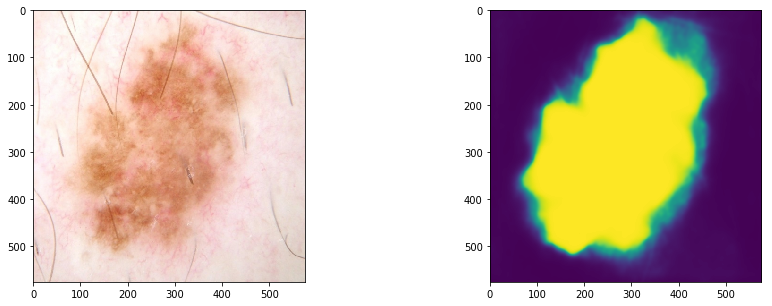

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


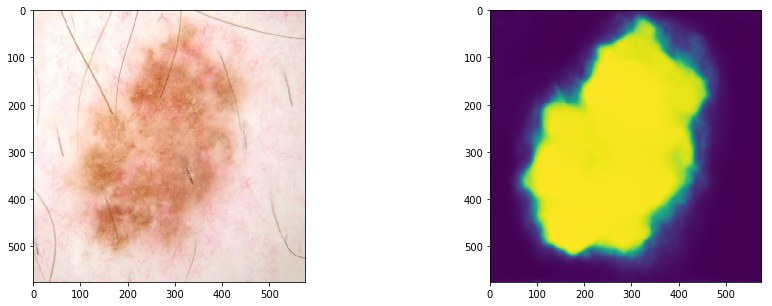

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


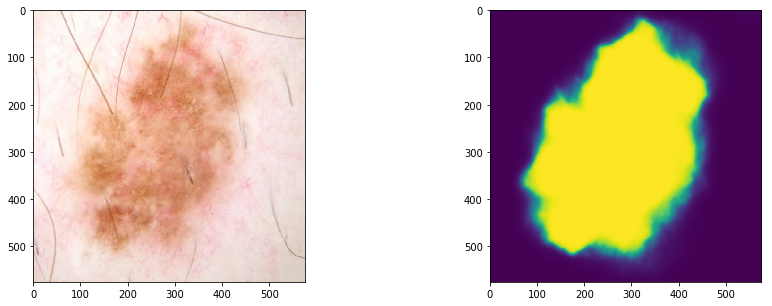

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


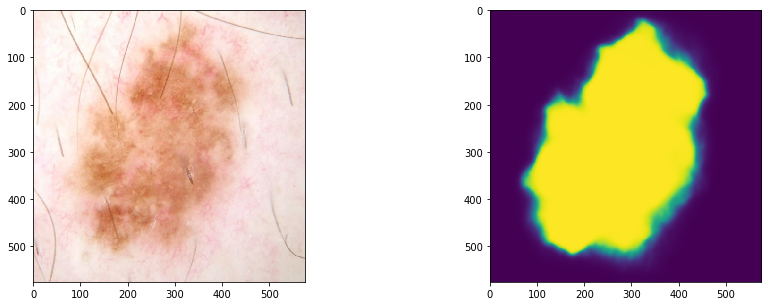

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


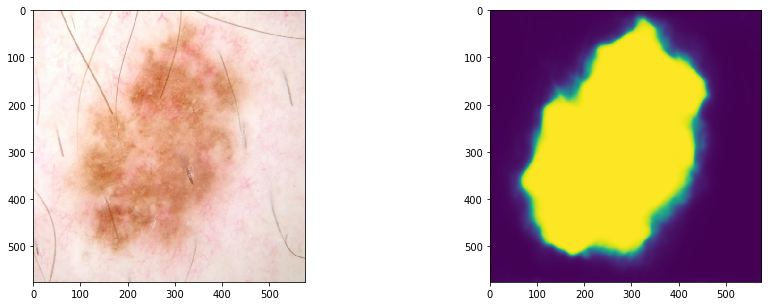

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


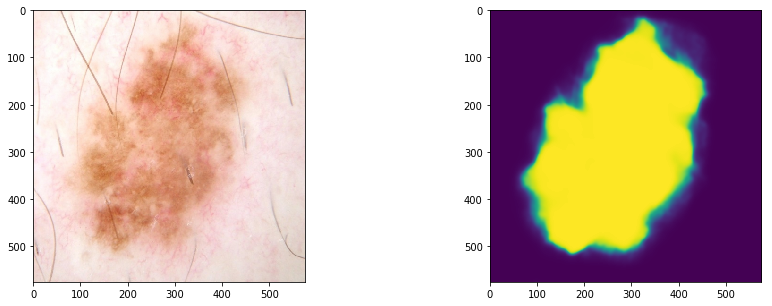

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


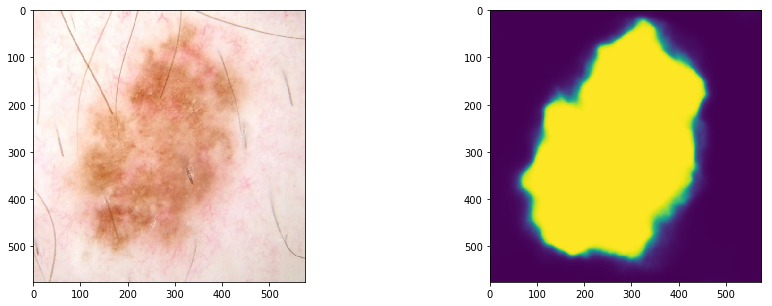

In [21]:
FOLD = 1

for i in range(20, 30):
    image = np.load('pics/image_fold_{}_val_idx_{}_epoch_{}.npy'.format(FOLD, 0, i))
    pred_mask = np.load('pics/pred_mask_fold_{}_val_idx_{}_epoch_{}.npy'.format(FOLD, 0, i))

    if True:
        _, ax = plt.subplots(ncols=2, figsize=(15, 5))
        ax[0].imshow(image)
#         ax[1].imshow(true_mask[..., 0])
        ax[1].imshow(pred_mask[..., 0])
    plt.show()
# np.save('pics/image_{}'.format(suffix), image)
# np.save('pics/pred_mask_{}'.format(suffix), pred_mask)
# np.save('pics/true_mask_{}'.format(suffix), true_mask)